# MP1 : Image Classification and Regression

In [1]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, Conv3D, advanced_activations, UpSampling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 3. Simple Classification

Here we will generate the dataset

In [4]:
nb_samples = 300
[X_train1, Y_train1] = generate_dataset_classification(nb_samples, 20)

print('X_train1 shape:', X_train1.shape)
print('Y_train1 shape:', Y_train1.shape) #5184 = 72 x 72 (IMAGE_SIZE =72)

X_train1 shape: (300, 5184)
Y_train1 shape: (300,)


Taking a look at the training sample

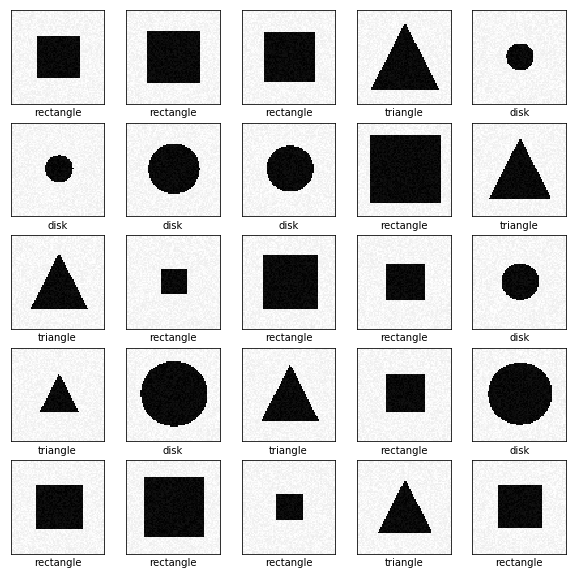

In [5]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train1[i].reshape(72,72), cmap= 'gray')
    plt.xlabel(class_names[int(Y_train1[i])])

Reformating the output: transforming the output (0, 1 or 2) corresponding to (rectangle, disk, triangle) into a 3-element vector containing 1 for the predicted class

In [6]:
y_train1 = np_utils.to_categorical(Y_train1, 3)

Lets look at some examples

In [9]:
print('before:', Y_train1[0])
print('after:', y_train1[0])

before: 0.0
after: [1. 0. 0.]


In [10]:
print('X_train1 shape:', X_train1.shape)
print('y_train1 shape:', y_train1.shape)

X_train1 shape: (300, 5184)
y_train1 shape: (300, 3)


### 3.1 Stochastic Gradient Descent

In [11]:
#Model with SGD optimization
model_sgd = Sequential()

model_sgd.add(Dense(16,activation='relu'))
model_sgd.add(Dense(3, activation = 'softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_sgd.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

model_sgd.fit(X_train1, y_train1, epochs=20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 2s 10ms/step - loss: 0.2185 - acc: 0.4625 - val_loss: 0.2045 - val_acc: 0.5500
Epoch 2/20
240/240 [==============================] - 0s 150us/step - loss: 0.2038 - acc: 0.5292 - val_loss: 0.2013 - val_acc: 0.5833
Epoch 3/20
240/240 [==============================] - 0s 208us/step - loss: 0.1918 - acc: 0.5417 - val_loss: 0.1788 - val_acc: 0.6167
Epoch 4/20
240/240 [==============================] - 0s 217us/step - loss: 0.1804 - acc: 0.5250 - val_loss: 0.1675 - val_acc: 0.5833
Epoch 5/20
240/240 [==============================] - 0s 204us/step - loss: 0.1683 - acc: 0.5667 - val_loss: 0.1582 - val_acc: 0.7000
Epoch 6/20
240/240 [==============================] - 0s 217us/step - loss: 0.1602 - acc: 0.6167 - val_loss: 0.1507 - val_acc: 0.7667
Epoch 7/20
240/240 [==============================] - 0s 196us/step - loss: 0.1504 - acc: 0.6708 - val_loss: 0.1481 - val_acc: 0.7500
Epoch 8/20
240/240

Let's generate a test set with it's prediction

In [13]:
[X_test1, Y_test1] = generate_dataset_classification(15, 20)
Y_pred_sgd = model_sgd.predict(X_test1)

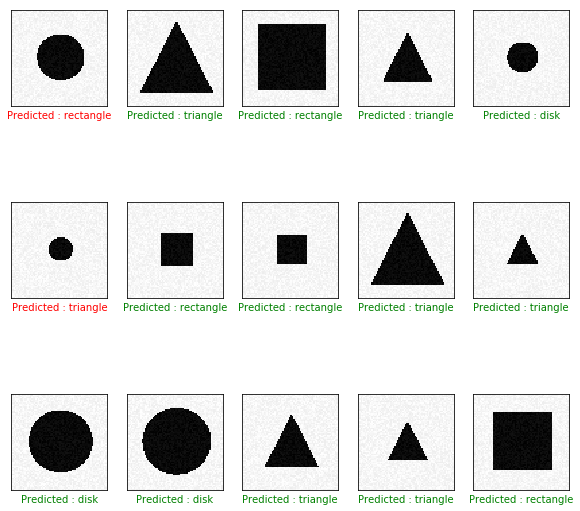

In [15]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test1[i].reshape(72,72), cmap= 'gray')
    prediction_i = Y_pred_sgd[i]
    list_pred_i = list(prediction_i)
    index_pred_i = list_pred_i.index(np.max(list_pred_i))
    if index_pred_i == Y_test1[i]:
        plt.xlabel('Predicted : ' + class_names[index_pred_i], color = 'g')
    else:
        plt.xlabel('Predicted : ' + class_names[index_pred_i], color = 'r')

### 3.2 Adam optimizer

In [32]:
#Model with SGD optimization
model_adam = Sequential()

model_adam.add(Dense(16,activation='relu'))
model_adam.add(Dense(3, activation = 'softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])

model_adam.fit(X_train1, y_train1, epochs=20, batch_size=30, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 2ms/step - loss: 1.4974 - acc: 0.3958 - val_loss: 1.3365 - val_acc: 0.3167
Epoch 2/20
240/240 [==============================] - 0s 192us/step - loss: 1.1307 - acc: 0.5042 - val_loss: 0.6806 - val_acc: 0.7333
Epoch 3/20
240/240 [==============================] - 0s 225us/step - loss: 0.7307 - acc: 0.6292 - val_loss: 0.6030 - val_acc: 0.7500
Epoch 4/20
240/240 [==============================] - 0s 229us/step - loss: 0.5592 - acc: 0.7542 - val_loss: 0.5296 - val_acc: 0.7500
Epoch 5/20
240/240 [==============================] - 0s 221us/step - loss: 0.4705 - acc: 0.8667 - val_loss: 0.4581 - val_acc: 0.8333
Epoch 6/20
240/240 [==============================] - 0s 246us/step - loss: 0.4084 - acc: 0.8875 - val_loss: 0.3810 - val_acc: 0.9833
Epoch 7/20
240/240 [==============================] - 0s 229us/step - loss: 0.3729 - acc: 0.8958 - val_loss: 0.3457 - val_acc: 0.9833
Epoch 8/20
240/240 

Generating a test set and the prediction

In [33]:
Y_pred_adam = model_adam.predict(X_test1)

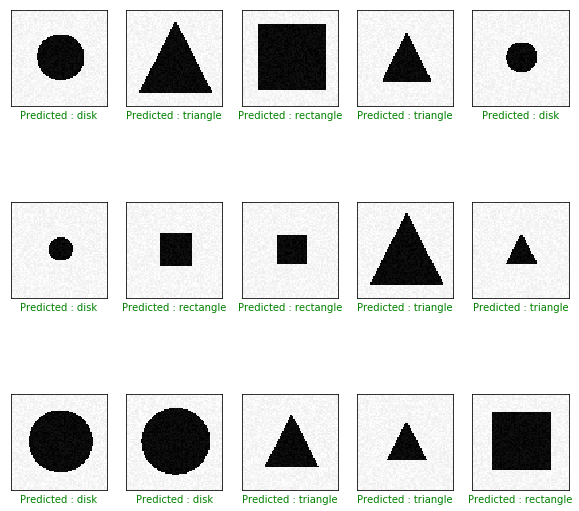

In [34]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test1[i].reshape(72,72), cmap= 'gray')
    prediction_i = Y_pred_adam[i]
    list_pred_i = list(prediction_i)
    index_pred_i = list_pred_i.index(np.max(list_pred_i))
    if index_pred_i == Y_test1[i]:
        plt.xlabel('Predicted : ' + class_names[index_pred_i], color = 'g')
    else:
        plt.xlabel('Predicted : ' + class_names[index_pred_i], color = 'r')

## 4. Visualization of the solution

In [35]:
W_adam = model_adam.get_weights()[0] @ model_adam.get_weights()[2]
W_adam.shape

(5184, 3)

In [36]:
b_adam = model_adam.get_weights()[3] 
b_adam.shape

(3,)

Text(0.5, 1.0, 'Adam: Third column')

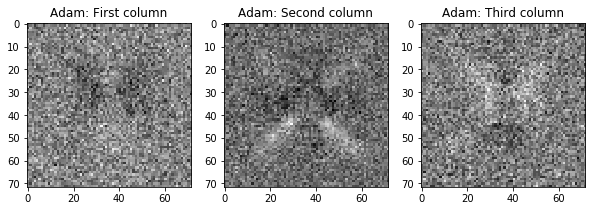

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(W_adam[:,0].reshape(72,72), cmap='gray')
axes[0].set_title('Adam: First column')

axes[1].imshow(W_adam[:,1].reshape(72,72), cmap='gray')
axes[1].set_title('Adam: Second column')

axes[2].imshow(W_adam[:,2].reshape(72,72), cmap='gray')
axes[2].set_title('Adam: Third column')

## 5. A more difficult classification problem

In this part, we will generate and reshape X_train and Y_train

In [39]:
[X_train2, Y_train2] = generate_dataset_classification(700, 20, True)

X_train2 = X_train2.reshape((700, 72, 72, 1))
y_train2 = np_utils.to_categorical(Y_train2, 3)

In [40]:
print('X_train2 shape:', X_train2.shape)
print('y_train2 shape:', y_train2.shape)

X_train2 shape: (700, 72, 72, 1)
y_train2 shape: (700, 3)


In [41]:
model1 = Sequential()

#Convolutional Layer with 16 (5x5) filters, activation is ReLu
model1.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model1.output_shape)

#Pooling Layer
model1.add(MaxPooling2D(pool_size=(2, 2)))
print(model1.output_shape)

#Flattening before Fully Connected Layers
model1.add(Flatten())
print(model1.output_shape)

#Fully Connected Layers
#model1.add(Dense(128, activation='relu'))
#model1.add(Dropout(0.2))
model1.add(Dense(3, activation = 'softmax'))
print(model1.output_shape)

#Optimization
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
model1.fit(X_train2, y_train2, epochs= 32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
(None, 3)
Epoch 1/32
700/700 [==============================] - 3s 5ms/step - loss: 1.0487 - acc: 0.4329
Epoch 2/32
700/700 [==============================] - 2s 3ms/step - loss: 0.7661 - acc: 0.7014
Epoch 3/32
700/700 [==============================] - 2s 3ms/step - loss: 0.6716 - acc: 0.7457
Epoch 4/32
700/700 [==============================] - 3s 4ms/step - loss: 0.5699 - acc: 0.8100
Epoch 5/32
700/700 [==============================] - 3s 4ms/step - loss: 0.5061 - acc: 0.8286
Epoch 6/32
700/700 [==============================] - 3s 4ms/step - loss: 0.4474 - acc: 0.8629
Epoch 7/32
700/700 [==============================] - 3s 4ms/step - loss: 0.4062 - acc: 0.8714
Epoch 8/32
700/700 [==============================] - 2s 3ms/step - loss: 0.3824 - acc: 0.8729
Epoch 9/32
700/700 [==============================] - 2s 3ms/step - loss: 0.3358 - acc: 0.9029
Epoch 10/32
700/700 [==============================] - 2s 3ms/step - loss: 0.2776 -

Generating X_test and Y_test

In [42]:
[X_test2, Y_test2] = generate_test_set_classification()

print('X_test2 shape:', X_test2.shape)
print('Y_test2 shape:', Y_test2.shape)

X_test2 shape: (300, 5184)
Y_test2 shape: (300, 3)


Reshaping X_test and Y_test

In [43]:
X_test2 = X_test2.reshape((300, 72, 72, 1))
y_test2 = Y_test2

print('X_test2 shape:', X_test2.shape)
print('y_test2 shape:', y_test2.shape)

X_test2 shape: (300, 72, 72, 1)
y_test2 shape: (300, 3)


Evaluation of the model: returns (loss function, accuracy)

In [44]:
model1.evaluate(X_test2, y_test2)

300/300 [==============================] - 1s 3ms/step


[0.4044218118985494, 0.8633333333333333]

In [45]:
y_pred2 = model1.predict(X_test2)

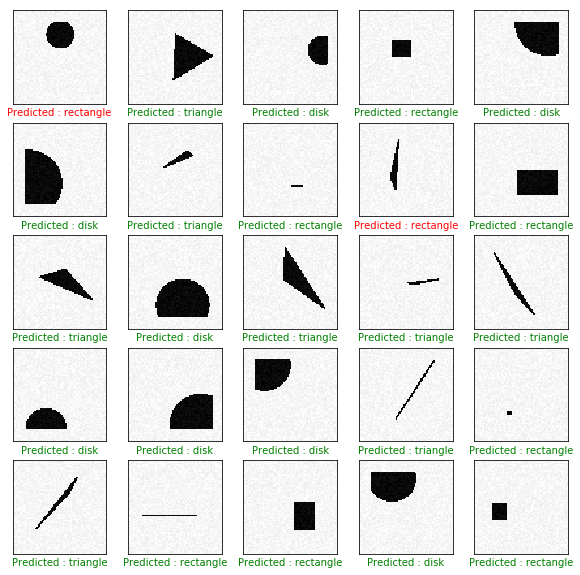

In [50]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test2[i].reshape(72,72), cmap= 'gray')
    
    prediction_i = y_pred2[i]
    list_pred_i = list(prediction_i)
    index_pred_i = list_pred_i.index(np.max(list_pred_i))
    
    index_to_predict = list(y_test2[i]).index(np.max(list(y_test2[i])))
    
    if index_pred_i == index_to_predict:
        plt.xlabel('Predicted : ' + class_names[index_pred_i], color = 'g')
    else:
        plt.xlabel('Predicted : ' + class_names[index_pred_i], color = 'r')

## 6 - A Regression Problem

In [51]:
[X_train3, Y_train3] = generate_dataset_regression(600, 20)

print('X_train3 shape:', X_train3.shape)
print('Y_train3 shape:', Y_train3.shape)

X_train3 shape: (600, 5184)
Y_train3 shape: (600, 6)


In [52]:
def normalize_Y(array):
    array_normalized = np.copy(array)
    nb_samples = array.shape[0]
    
    for k in range(nb_samples):
        vertices = list(array[k])
        vertices_sorted = []
        x1, y1, x2, y2, x3, y3 = vertices[0], vertices[1], vertices[2], vertices[3], vertices[4], vertices[5]

        mydict = {y1:x1, y2:x2, y3:x3}
        keylist = list(mydict.keys())
        keylist.sort(reverse = True)
        for key in keylist:
            vertices_sorted.append(mydict[key])
            vertices_sorted.append(key)

        array_normalized[k] = vertices_sorted
        
    return(array_normalized)

In [53]:
X_train3 = X_train3.reshape((600, 72, 72, 1))
y_train3 = normalize_Y(Y_train3)

print('X_train3 shape:', X_train3.shape)
print('y_train3 shape:', y_train3.shape)

X_train3 shape: (600, 72, 72, 1)
y_train3 shape: (600, 6)


Taking a look at a training example

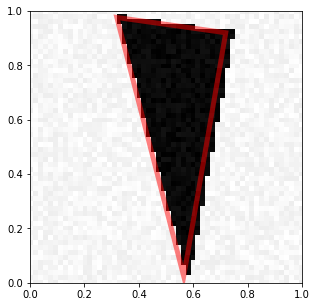

In [54]:
visualize_prediction(X_train3[0], y_train3[0])

Regression model: Convolutional then Fully Connected with a final linear activation returning 6 values for the 6 coordinates

In [55]:
model2 = Sequential()

#Convolutional Layer with activation ReLu
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

#Flattening before Fully Connected Layers
model2.add(Flatten())

#Fully Connected Layers
model2.add(Dense(128, activation='relu'))

model2.add(Dropout(0.3))

model2.add(Dense(128, activation='relu'))

model2.add(Dense(6, activation = 'linear'))
#print(model2.output_shape)

#Optimization
model2.compile(loss='mean_squared_error', optimizer='adam')   
model2.fit(X_train3, y_train3, epochs= 25, batch_size = 20, validation_split = 0.4)

Train on 360 samples, validate on 240 samples
Epoch 1/25
360/360 [==============================] - 7s 19ms/step - loss: 0.1060 - val_loss: 0.0645
Epoch 2/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0610 - val_loss: 0.0496
Epoch 3/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0456 - val_loss: 0.0330
Epoch 4/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0403 - val_loss: 0.0331
Epoch 5/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0358 - val_loss: 0.0276
Epoch 6/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0333 - val_loss: 0.0283
Epoch 7/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0304 - val_loss: 0.0289
Epoch 8/25
360/360 [==============================] - 5s 14ms/step - loss: 0.0278 - val_loss: 0.0252
Epoch 9/25
360/360 [==============================] - 5s 13ms/step - loss: 0.0259 - val_loss: 0.0230
Epoch 10/25
360/360 [========================

In [56]:
[X_test3, Y_test3] = generate_test_set_regression()

print('X_test3 shape:', X_test3.shape)
print('Y_test3 shape:', Y_test3.shape)

X_test3 shape: (300, 5184)
Y_test3 shape: (300, 6)


In [59]:
X_test3 = X_test3.reshape((300, 72, 72, 1))
y_test3 = normalize_Y(Y_test3)

print('X_test3 shape:', X_test3.shape)
print('y_test3 shape:', y_test3.shape)

X_test3 shape: (300, 72, 72, 1)
y_test3 shape: (300, 6)


In [60]:
print(Y_test3[0])
print(y_test3[0])

[0.94133439 0.93818117 0.67661723 0.27556678 0.36340393 0.33217252]
[0.94133439 0.93818117 0.36340393 0.33217252 0.67661723 0.27556678]


In [61]:
model2.evaluate(X_test3, y_test3)

300/300 [==============================] - 1s 4ms/step


0.012020415365695954

In [62]:
y_pred3 = model2.predict(X_test3)

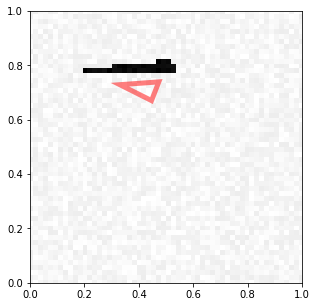

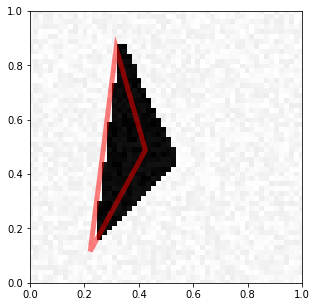

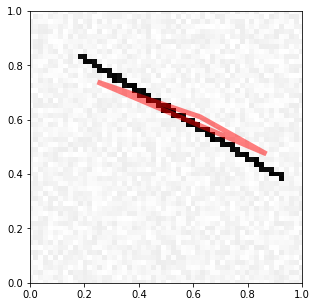

In [63]:
visualize_prediction(X_test3[1], y_pred3[1])
visualize_prediction(X_test3[2], y_pred3[2])
visualize_prediction(X_test3[3], y_pred3[3])

## 7 - Image Denoising

In [64]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_bis(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noised = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noised, imdata

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_bis(figsize, U, V, noise)


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_bis(figsize, U, V, noise)

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata_noised, imdata = generate_a_drawing_bis(figsize, U, V, noise)
    return [imdata_noised, imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification_bis(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_bis()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    #print('Creating data:')
    for i in range(nb_samples):
        noise_i = np.random.randint(255)
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_bis(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_bis(noise, free_location)
        else:
            [X[i], Y[i], V] = generate_a_triangle_bis(noise, free_location)
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        Y[i] = Y[i] / 255
    return [X, Y]

def generate_test_set_classification_bis():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_bis(300, 20, True)
    return [X_test, Y_test]

In [65]:
X_noised_train, Y_denoised_train = generate_dataset_classification_bis(600, 50, True)

In [66]:
X_noised_train = X_noised_train.reshape((600, 72, 72, 1))
Y_denoised_train = Y_denoised_train.reshape((600, 72, 72, 1))

print('X_noised_train shape:', X_noised_train.shape)
print('Y_denoised_train shape:', Y_denoised_train.shape)

X_noised_train shape: (600, 72, 72, 1)
Y_denoised_train shape: (600, 72, 72, 1)


In [68]:
X_noised_test, Y_denoised_test = generate_test_set_classification_bis()

Text(0.5, 1.0, 'Denoised image generated')

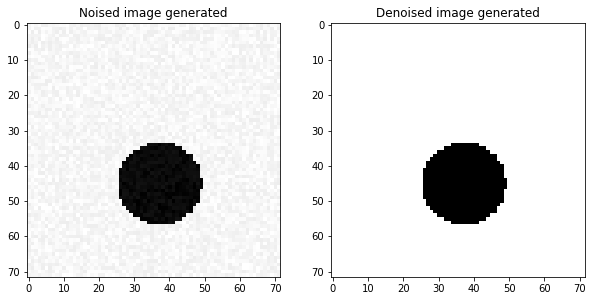

In [69]:
f, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].imshow(X_noised_test[2].reshape(72,72), cmap= 'gray')
axes[0].set_title('Noised image generated')
    
axes[1].imshow(Y_denoised_test[2].reshape(72,72), cmap= 'gray')
axes[1].set_title('Denoised image generated')


In [70]:
X_noised_test = X_noised_test.reshape((300, 72, 72, 1))
Y_denoised_test = Y_denoised_test.reshape((300, 72, 72, 1))

print('X_noised_test shape:', X_noised_test.shape)
print('Y_denoised_test shape:', Y_denoised_test.shape)

X_noised_test shape: (300, 72, 72, 1)
Y_denoised_test shape: (300, 72, 72, 1)


In [71]:
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(3,3),activation='linear',input_shape=(72,72,1), padding='same'))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(MaxPooling2D(pool_size=(2, 2)))
print(model3.output_shape)

model3.add(Conv2D(64, kernel_size=(3,3),activation='linear', padding='same'))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(MaxPooling2D(pool_size=(2, 2)))
print(model3.output_shape)

model3.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(UpSampling2D(size=(2, 2)))
print(model3.output_shape)

model3.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model3.add(UpSampling2D(size=(2, 2)))
model3.add(advanced_activations.LeakyReLU(alpha=0.1))
print(model3.output_shape)

model3.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model3.compile(loss='mean_squared_error', optimizer = adam ,metrics=['accuracy'])

model3.fit(X_noised_train, Y_denoised_train, epochs= 30, batch_size = 20, validation_split = 0.4)

(None, 72, 72, 32)
(None, 36, 36, 32)
(None, 36, 36, 64)
(None, 18, 18, 64)
(None, 18, 18, 32)
(None, 36, 36, 32)
(None, 72, 72, 32)
Train on 360 samples, validate on 240 samples
Epoch 1/30
360/360 [==============================] - 15s 43ms/step - loss: 0.1161 - acc: 0.8641 - val_loss: 0.0817 - val_acc: 0.9142
Epoch 2/30
360/360 [==============================] - 15s 41ms/step - loss: 0.0702 - acc: 0.9135 - val_loss: 0.0380 - val_acc: 0.9677
Epoch 3/30
360/360 [==============================] - 13s 37ms/step - loss: 0.0154 - acc: 0.9849 - val_loss: 0.0066 - val_acc: 0.9914
Epoch 4/30
360/360 [==============================] - 13s 36ms/step - loss: 0.0066 - acc: 0.9912 - val_loss: 0.0061 - val_acc: 0.9917
Epoch 5/30
360/360 [==============================] - 13s 36ms/step - loss: 0.0055 - acc: 0.9928 - val_loss: 0.0055 - val_acc: 0.9931
Epoch 6/30
360/360 [==============================] - 14s 38ms/step - loss: 0.0050 - acc: 0.9936 - val_loss: 0.0048 - val_acc: 0.9939
Epoch 7/30
360/36

In [72]:
Y_pred_denoised = model3.predict(X_noised_test)

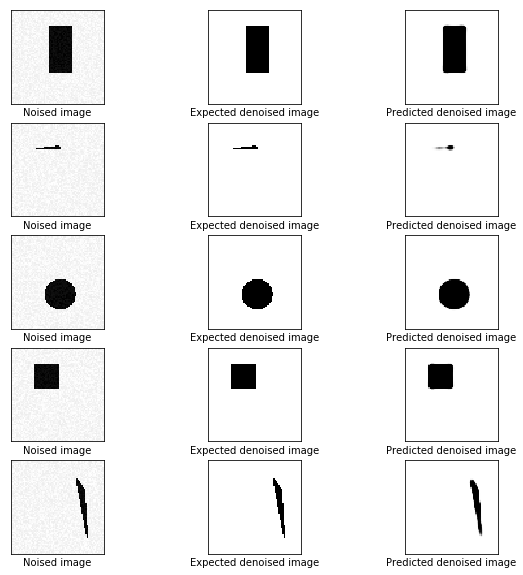

In [73]:
plt.figure(figsize=(10,10))
c = 5
for i in range(5):
    for k in range(1,4):
        plt.subplot(5,3,3*i+k)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if k ==1:
            plt.imshow(X_noised_test[i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Noised image')
        elif k ==2:
            plt.imshow(Y_denoised_test[i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Expected denoised image')
        elif k ==3:
            plt.imshow(Y_pred_denoised[i].reshape(72,72), cmap= 'gray')
            plt.xlabel('Predicted denoised image')